# 3. Characterizing underperformed Real-Estate companies 1-Month Post-COVID19 Vaccine Success 

## Instructions
In 2020 August, the author attempted a characterization of [S&P500 companies based on fundamental metrics during covid19](https://medium.com/analytics-vidhya/characterising-companies-based-on-financial-metrics-during-covid19-1a6ce9cc4ada). Here, the author sought to characterize the performance of S&P500 companies 1-month after [the first covid19 vaccine success announcement by Pfizer](https://www.pfizer.com/news/press-release/press-release-detail/pfizer-and-biontech-conclude-phase-3-study-covid-19-vaccine) on the Nov 18, 2020. Briefly, the stock return was calculated based on the difference between the end of day (eod) stock prices on the Nov 17 and Dec 18, 2020. The contemporary fundamental metrics of the companies were retrieved to investigate their correlations with the top and worst performer during the month.

## Packages
You'll need to you install the quanp package (https://quanp.readthedocs.io/en/latest/installation.html) that should install all necessary packages/libraries required to execute the codes in this tutorial. Please create and use virtualenv with python version 3.6 to avoid dependency problem.

### Install Packages

In [1]:
# import sys
# !conda install seaborn scikit-learn statsmodels numba pytables
# !conda install -c conda-forge python-igraph leidenalg
# !{sys.executable} -m pip install quanp

In [2]:
# importing library packages
from datetime import datetime, timedelta
import os

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import quanp as qp
import re

from IPython.display import display
from matplotlib import rcParams

# setting visualization/logging parameters
pd.set_option('display.max_columns', None)
qp.set_figure_params(dpi=100, color_map = 'viridis_r')
qp.settings.verbosity = 1
qp.logging.print_versions()

### Download data

In [8]:
# S&P 500 metadata
df_metadata = qp.datasets.get_wiki_sp500_metadata()

The metadata file has been initialized and saved as /Users/leehongkai/OneDrive/Finance/quanp/notebooks/data/metadata/sp500_metadata.csv


In [9]:
# S&P 500 fundamentals
df_fundamental = qp.datasets.download_tickers_fundamental()


Total tickers to download: 505


<class 'KeyError'> column 'BRK-B' not found in the processed dataframe. Possible reason may be the ticker provided not found in TOS database.


<class 'KeyError'> column 'BF-B' not found in the processed dataframe. Possible reason may be the ticker provided not found in TOS database.


Fundamentals appended sp500_metadata file has been save as /Users/leehongkai/OneDrive/Finance/quanp/notebooks/data/metadata/sp500_metadata_fundamentalAdded.csv


In [ ]:
# Download End of Day (eod) price history from the current sp500 list
qp.datasets.download_tickers_price_history_fromlist(df_metadata.index)

Total price history collected for JPM is < 2 - download                      discarded


### Loading and preparing data

In [ ]:
# Optional: The data retried in cell above were saved as csv file You may activated this cell to avoid 
# rerunning the downloading cell above.
df_fundamental = pd.read_csv('data/metadata/sp500_metadata_fundamentalAdded.csv', index_col=0)
print(df_fundamental.columns)

In [ ]:
# prepare End of Day (eod) for each company
df_eod = qp.datasets.process_eod_price(df_metadata.index, startdate='2020-11-17', enddate='2020-12-18')
df_eod

In [ ]:
# calculate the 1-month log return of the stock price for each company, i.e. price difference
# between Nov 17 and Dec 18, 2020.
df_log_return_1mth = pd.DataFrame(np.log(df_eod.iloc[-1]) - np.log(df_eod.iloc[0]), 
                                  columns=['log_return_1mth'])
df_log_return_1mth.describe()

In [ ]:
# merging fundamental data with the log_return data
df_fundamental_logreturn = pd.merge(df_fundamental, df_log_return_1mth, how='inner', left_index=True, right_index=True)

In [ ]:
ls_fundamental_target = ['log_return_1mth'] + ['beta','bookValuePerShare','currentRatio', 'quickRatio', 
'dividendYield', 'epsChangePercentTTM', 'epsChangeYear', 'epsTTM', 'grossMarginMRQ', 'grossMarginTTM', 
'interestCoverage', 'marketCap', 'marketCapFloat', 'netProfitMarginMRQ','netProfitMarginTTM', 
'operatingMarginMRQ', 'operatingMarginTTM', 'peRatio', 'pegRatio', 'pbRatio', 'pcfRatio',
'prRatio', 'returnOnAssets', 'returnOnEquity', 'returnOnInvestment', 'revChangeIn', 'revChangeTTM', 
'revChangeYear', 'sharesOutstanding', 'shortIntDayToCover', 'shortIntToFloat', 'totalDebtToCapital', 
'totalDebtToEquity', 'ltDebtToEquity', 'vol10DayAvg', 'vol1DayAvg', 'vol3MonthAvg']

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Minmax scaling (0, 1) for all the variables/features
scaler = MinMaxScaler()
df_fundamental_logreturn_minmax = pd.DataFrame(scaler.fit_transform(df_fundamental_logreturn[ls_fundamental_target]), 
                                  index=df_fundamental_logreturn.index,
                                  columns=ls_fundamental_target)

df_fundamental_logreturn_minmax[ls_fundamental_target].describe()

NameError: name 'df_fundamental_logreturn' is not defined

In [14]:
# Loading pandas dataframe as anndata 
adata = qp.AnnData(df_fundamental_logreturn_minmax[ls_fundamental_target])

# Saving raw data for visualization later
adata.raw = adata

# log(x+1) transformation for all data
qp.pp.log1p(adata)

# Standardization scaling per feature
qp.pp.scale(adata)

In [15]:
# add a new `.obs` column for all comapnanies called `GICS_Sector`
adata.obs['GICS_Sector'] = df_fundamental_logreturn['GICS Sector'].values

adata

AnnData object with n_obs × n_vars = 505 × 38
    obs: 'GICS_Sector'
    var: 'mean', 'std'
    uns: 'log1p'

### Principal component analysis (PCA)
Reduce the dimensionality of the data by running PCA, which reveals the main axes of variation and denoises the data.

In [16]:
qp.tl.pca(adata, svd_solver='arpack', random_state=42)

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function ```qp.tl.leiden()```, ```qp.tl.louvain()```, or ```tSNE qp.tl.tsne()```. In our experience, often, a rough estimate of the number of PCs does fine. The 'elbow' point seems to suggest at least up to PC5 will be useful to characterize the companies. We are going to do further dimensional reduction based on the first 6 PCs later. We will perform a factor analysis to check for the underlying features that made up these PCs in a separate tutorial notebook later.

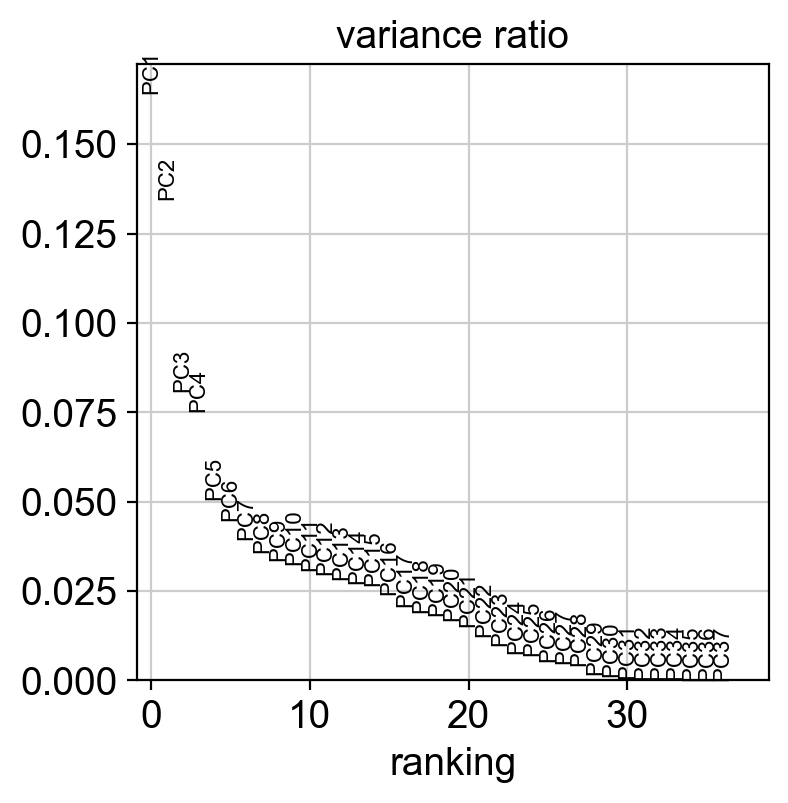

In [17]:
qp.pl.pca_variance_ratio(adata, n_pcs=len(adata.var_names))

In [18]:
# Optional: save the anndata in h5ad for reloading of the processed data later
adata.write('data/sp500_1mthlogreturn_afterVaccineSuccess.h5ad')
# adata.read('data/sp500_1mthlogreturn_afterVaccineSuccess.h5ad')
adata

/Users/leehongkai/anaconda/envs/quanp_py36/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'GICS_Sector' as categorical


AnnData object with n_obs × n_vars = 505 × 38
    obs: 'GICS_Sector'
    var: 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Computing the T-distributed Stochastic Neighbor Embedding (tSNE)

Let us further reduce the dimensionality of the signficant PCs identified above wholly in to 2 dimensions using the tSNE tool implemented as ```qp.tl.tsne(adata)```.

In [19]:
qp.tl.tsne(adata, n_pcs=6, random_state=42); # only consider the first 8 pcs

### Computing the neighborhood graph

Before we view the tsne plots with Sector annotations, Let us compute the neighborhood graph of companies using the PCA representation of the data matrix. This will give rise to distances and connectivities in each company. Here, we consider 10 nearest neighbors with 6 PCs derived from the PCA

In [20]:
qp.pp.neighbors(adata, n_neighbors=10, n_pcs=6, random_state=42);

### Clustering the neighborhood graph

Here, we use Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018) to cluster the neighborhood graph of companies, which we already computed in the previous section.

In [21]:
qp.tl.leiden(adata)

We can now map and view the annotations of leiden clustering, GICS_Sector, or any financial metrics/features on the tsne plots. We can see that companies from the Leiden Clusters 7 and 10 seems to perform the best 1 month post-vaccine-success, while the worst performers seem to be ones from the Clusters 2 and 9.

In [22]:
# # Check data distribution of the log_return_1mth to set a appropriate vmin cutoff
# df_fundamental_logreturn_minmax['log_return_1mth'].describe()

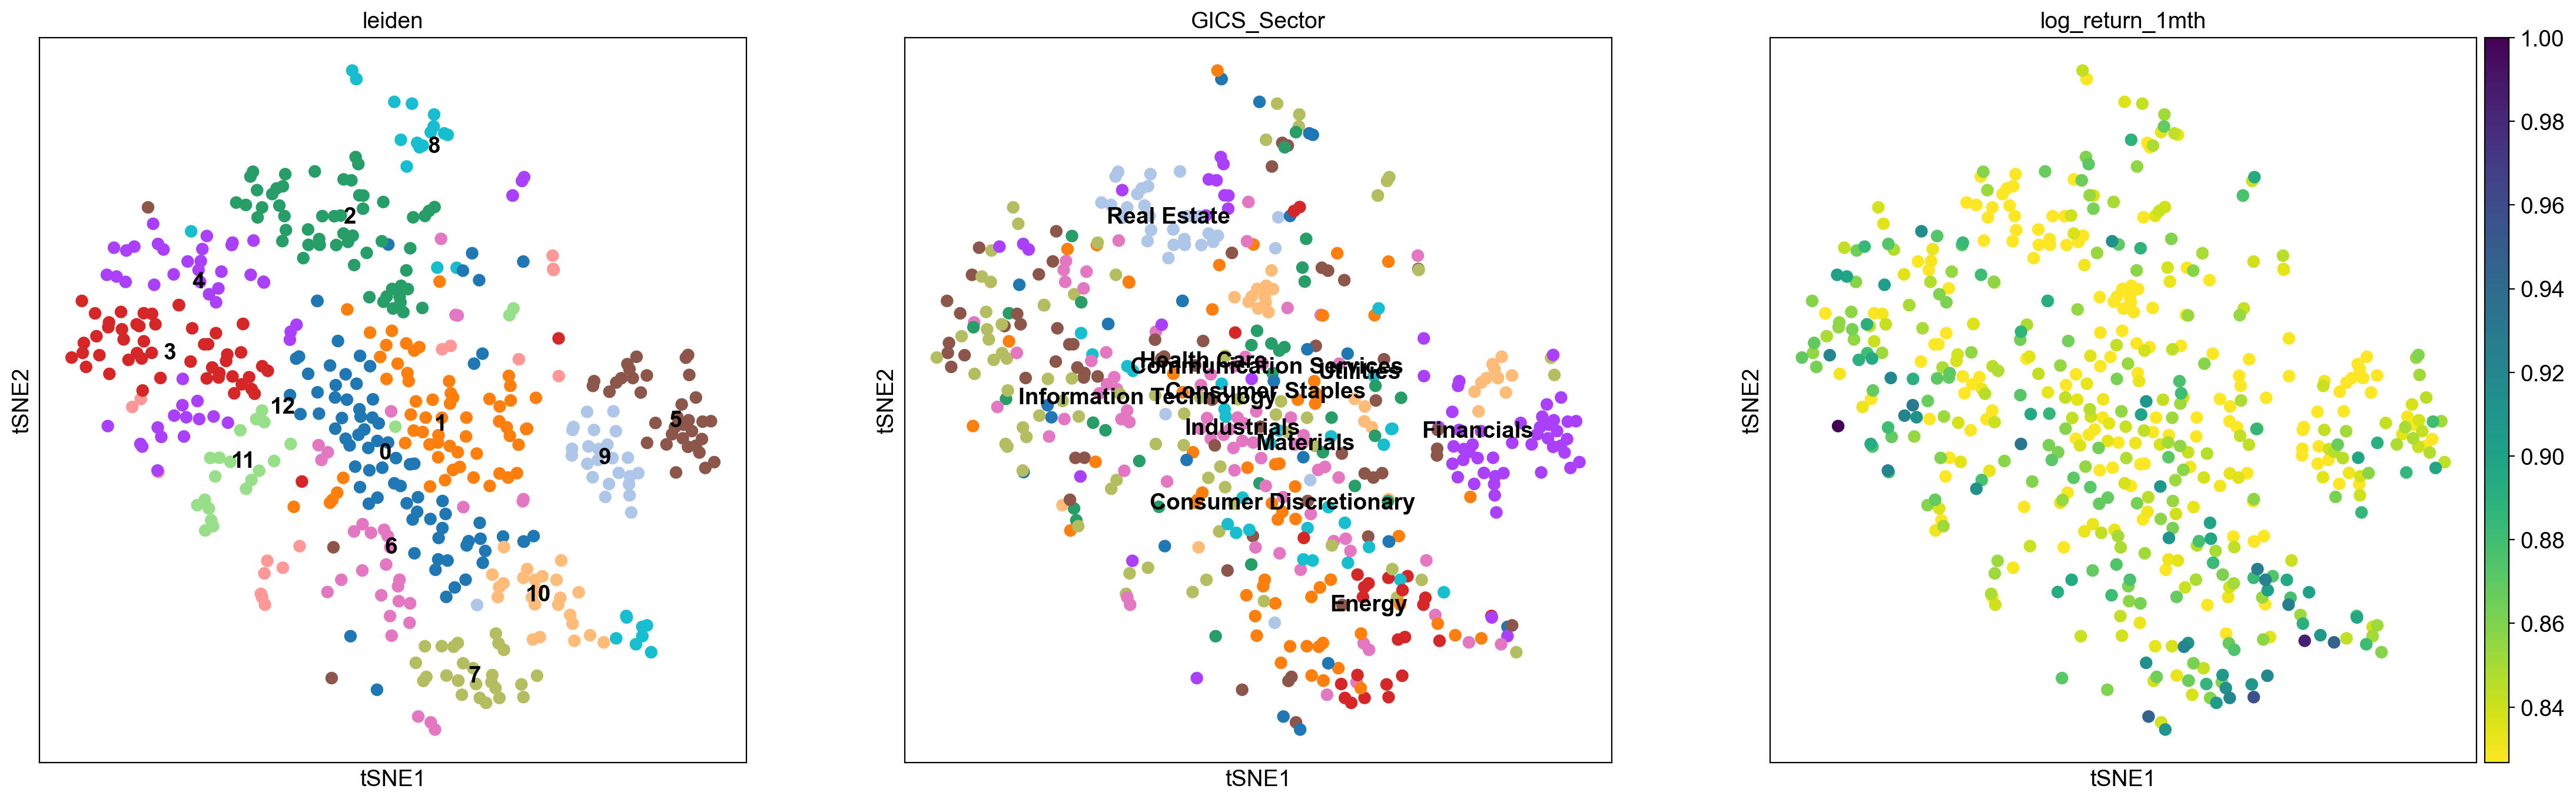

In [23]:
rcParams['figure.figsize'] = 8,8
qp.pl.tsne(adata, color=['leiden', 'GICS_Sector', 'log_return_1mth'], 
           vmin=0.826745, legend_loc='on data', use_raw=True)

### Embedding the neighborhood graph

We can also embed the neighborhood graph in 2 dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE. Before running the UMAP, we compute the correlations between clusters as initiating positions for the UMAP.

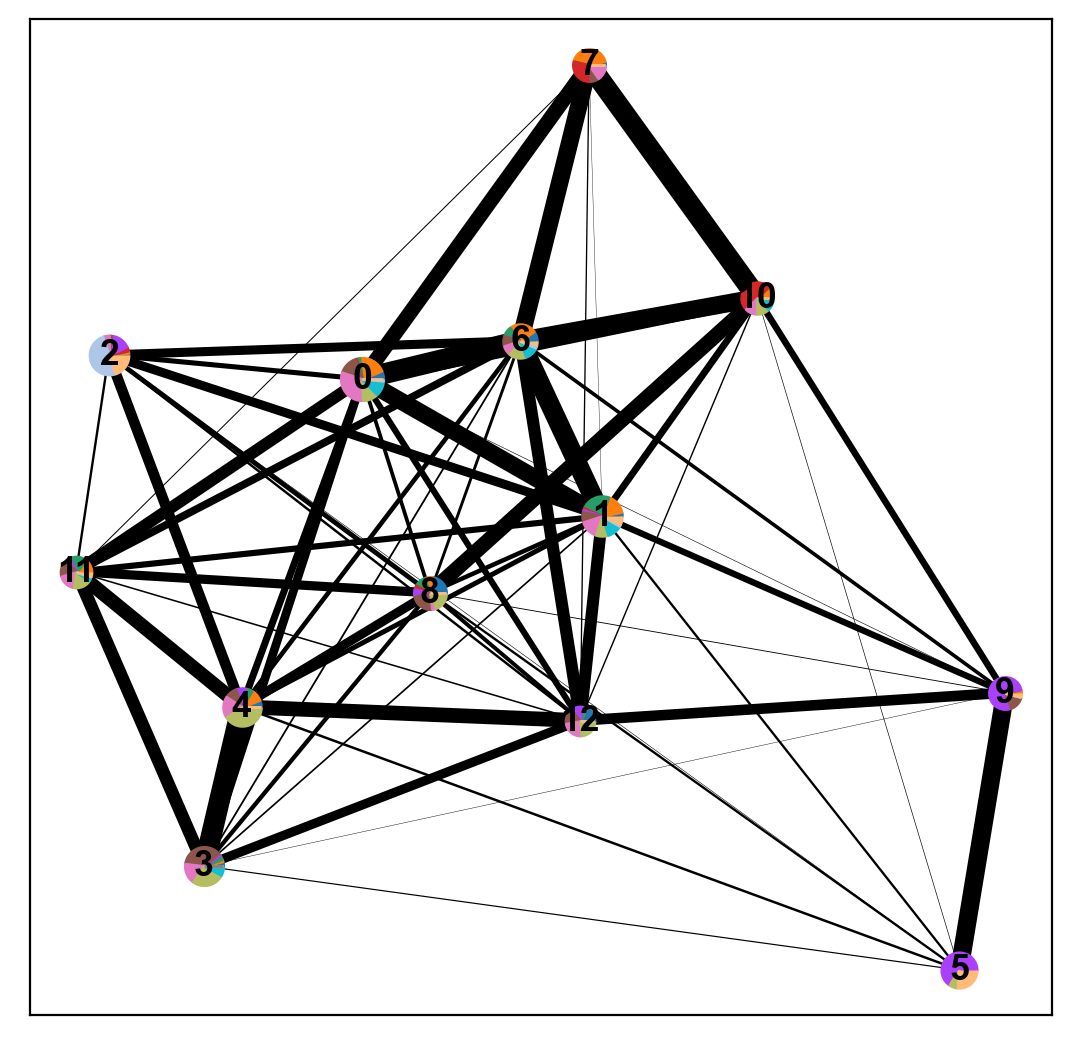

In [24]:
rcParams['figure.figsize'] = 6,6
qp.tl.paga(adata)
qp.pl.paga(adata, color=['GICS_Sector'], plot=True)

We can now map and view the annotations of leiden clustering, GICS_Sector, or any financial metrics/features on the umap plots. Again, we can see that companies from the Leiden Clusters 7 and 10 seems to perform the best 1 month post-vaccine-success, while the worst performers seem to be ones from the Clusters 2 and 9.

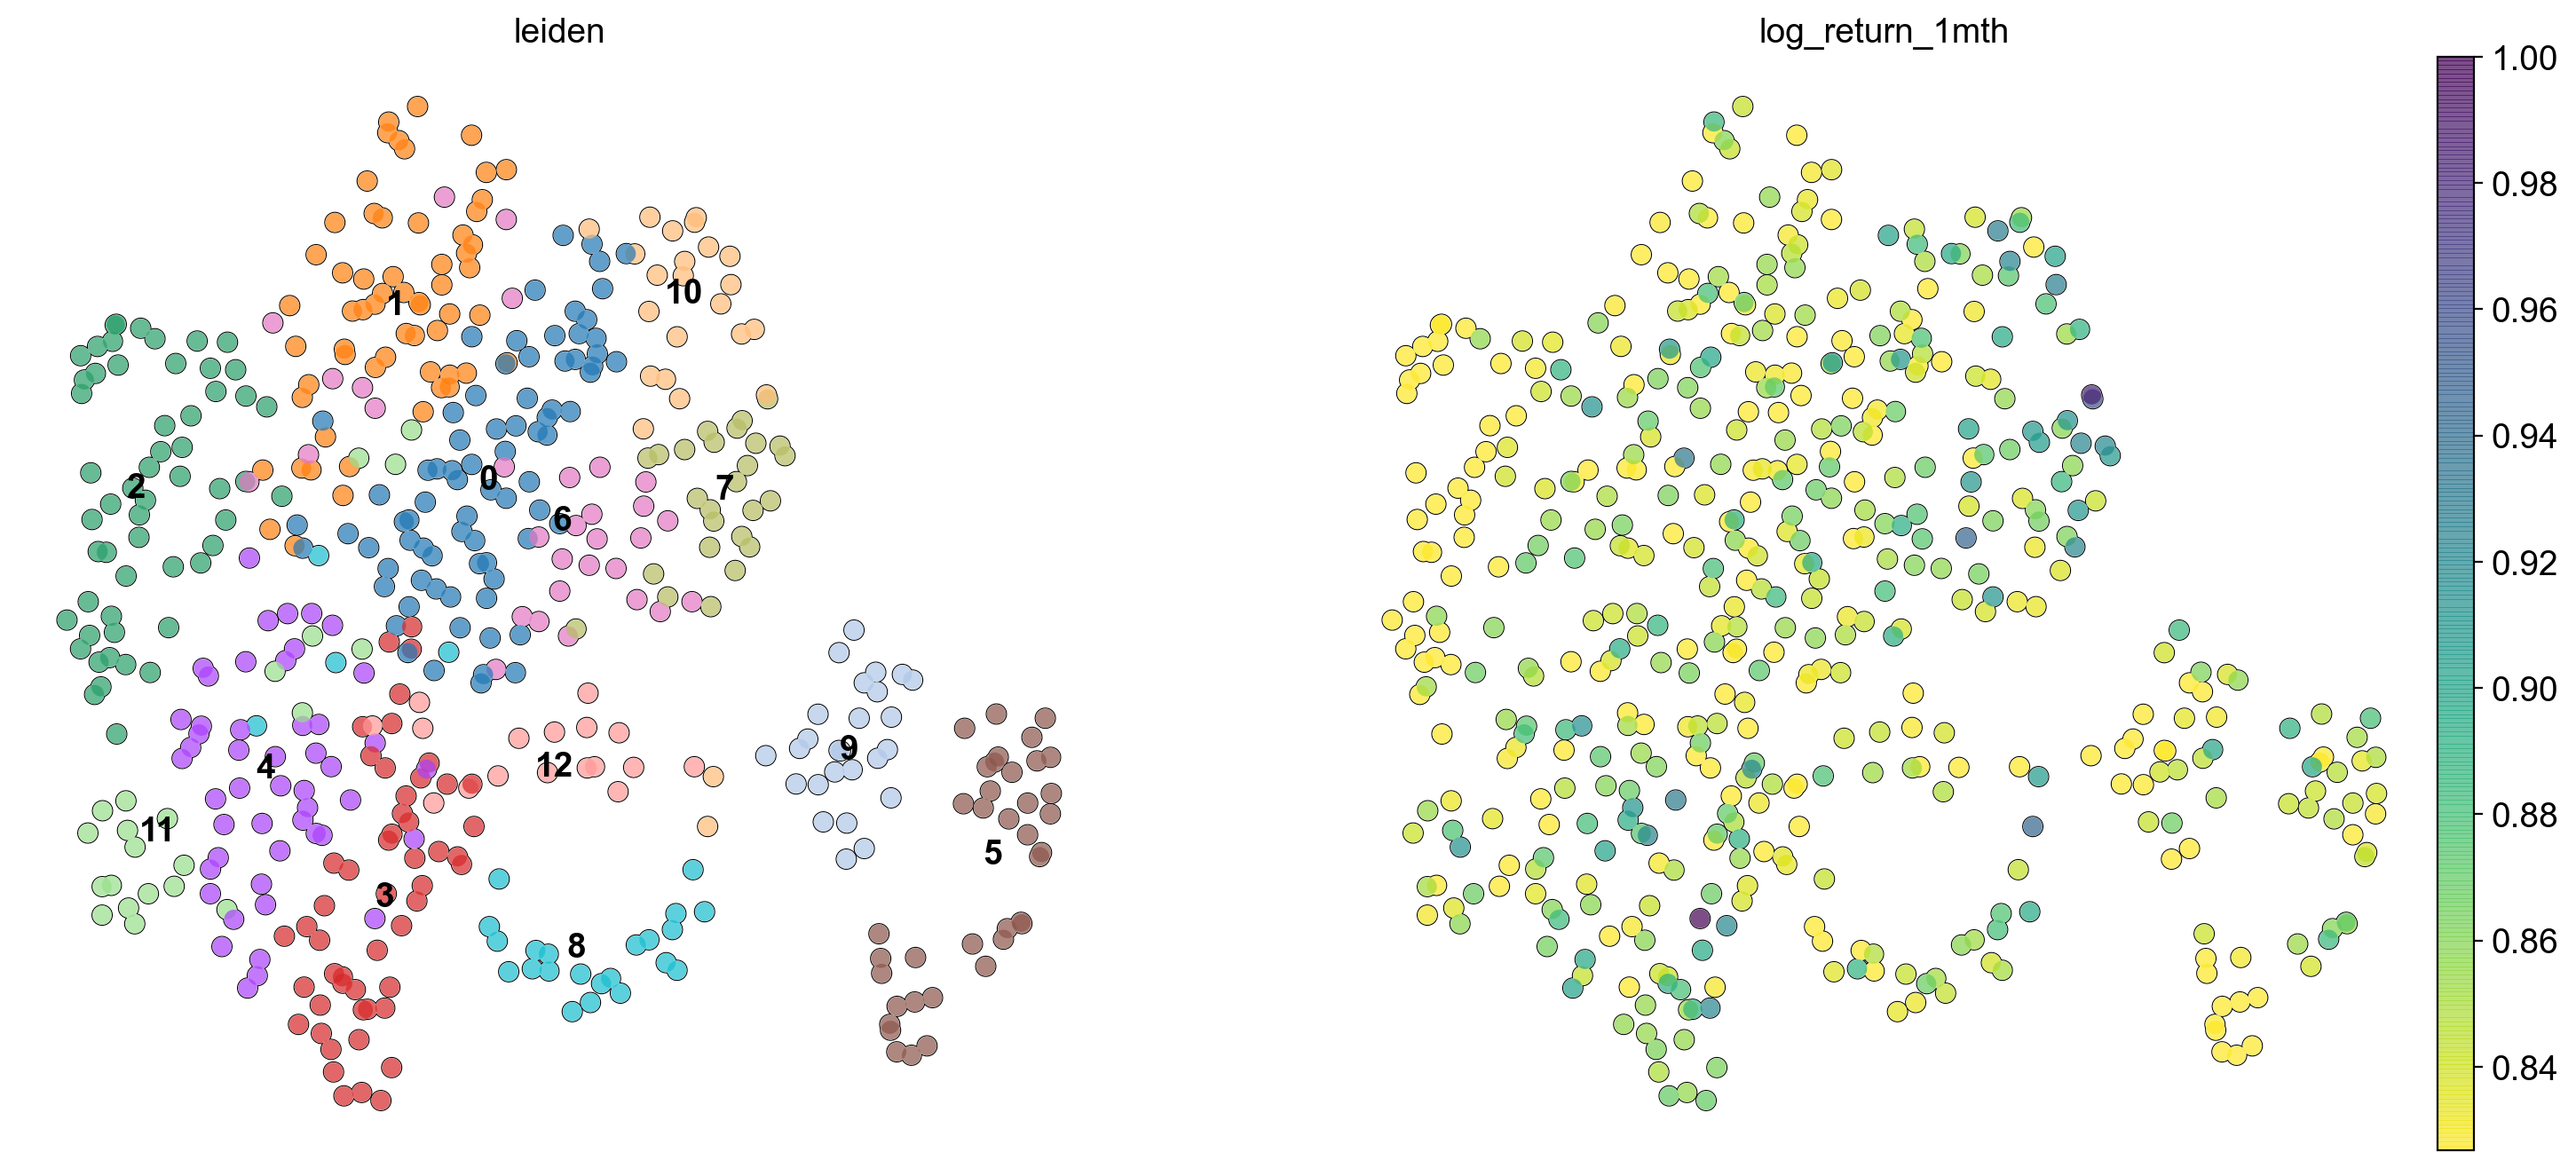

In [25]:
rcParams['figure.figsize'] = 8,8
qp.tl.umap(adata, init_pos='paga', random_state=42)
qp.pl.umap(adata, color=['leiden', 'log_return_1mth'], 
           legend_loc='on data', frameon=False, ncols=4, 
           vmin=0.826745, vmax=1.0, use_raw=True,
           add_outline=True, outline_width=(0.05, 0.01))

### Characterizing the clusters of companies

We run `qp.tl.dendrogram` to compute hierarchical clustering. Multiple visualizations that can
then include a dendrogram: `qp.pl.matrixplot`, `qp.pl.heatmap`, `qp.pl.dotplot` and `qp.pl.stacked_violin`. 

In [26]:
qp.tl.dendrogram(adata, 'leiden', var_names=adata.var_names);

/Users/leehongkai/anaconda/envs/quanp_py36/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


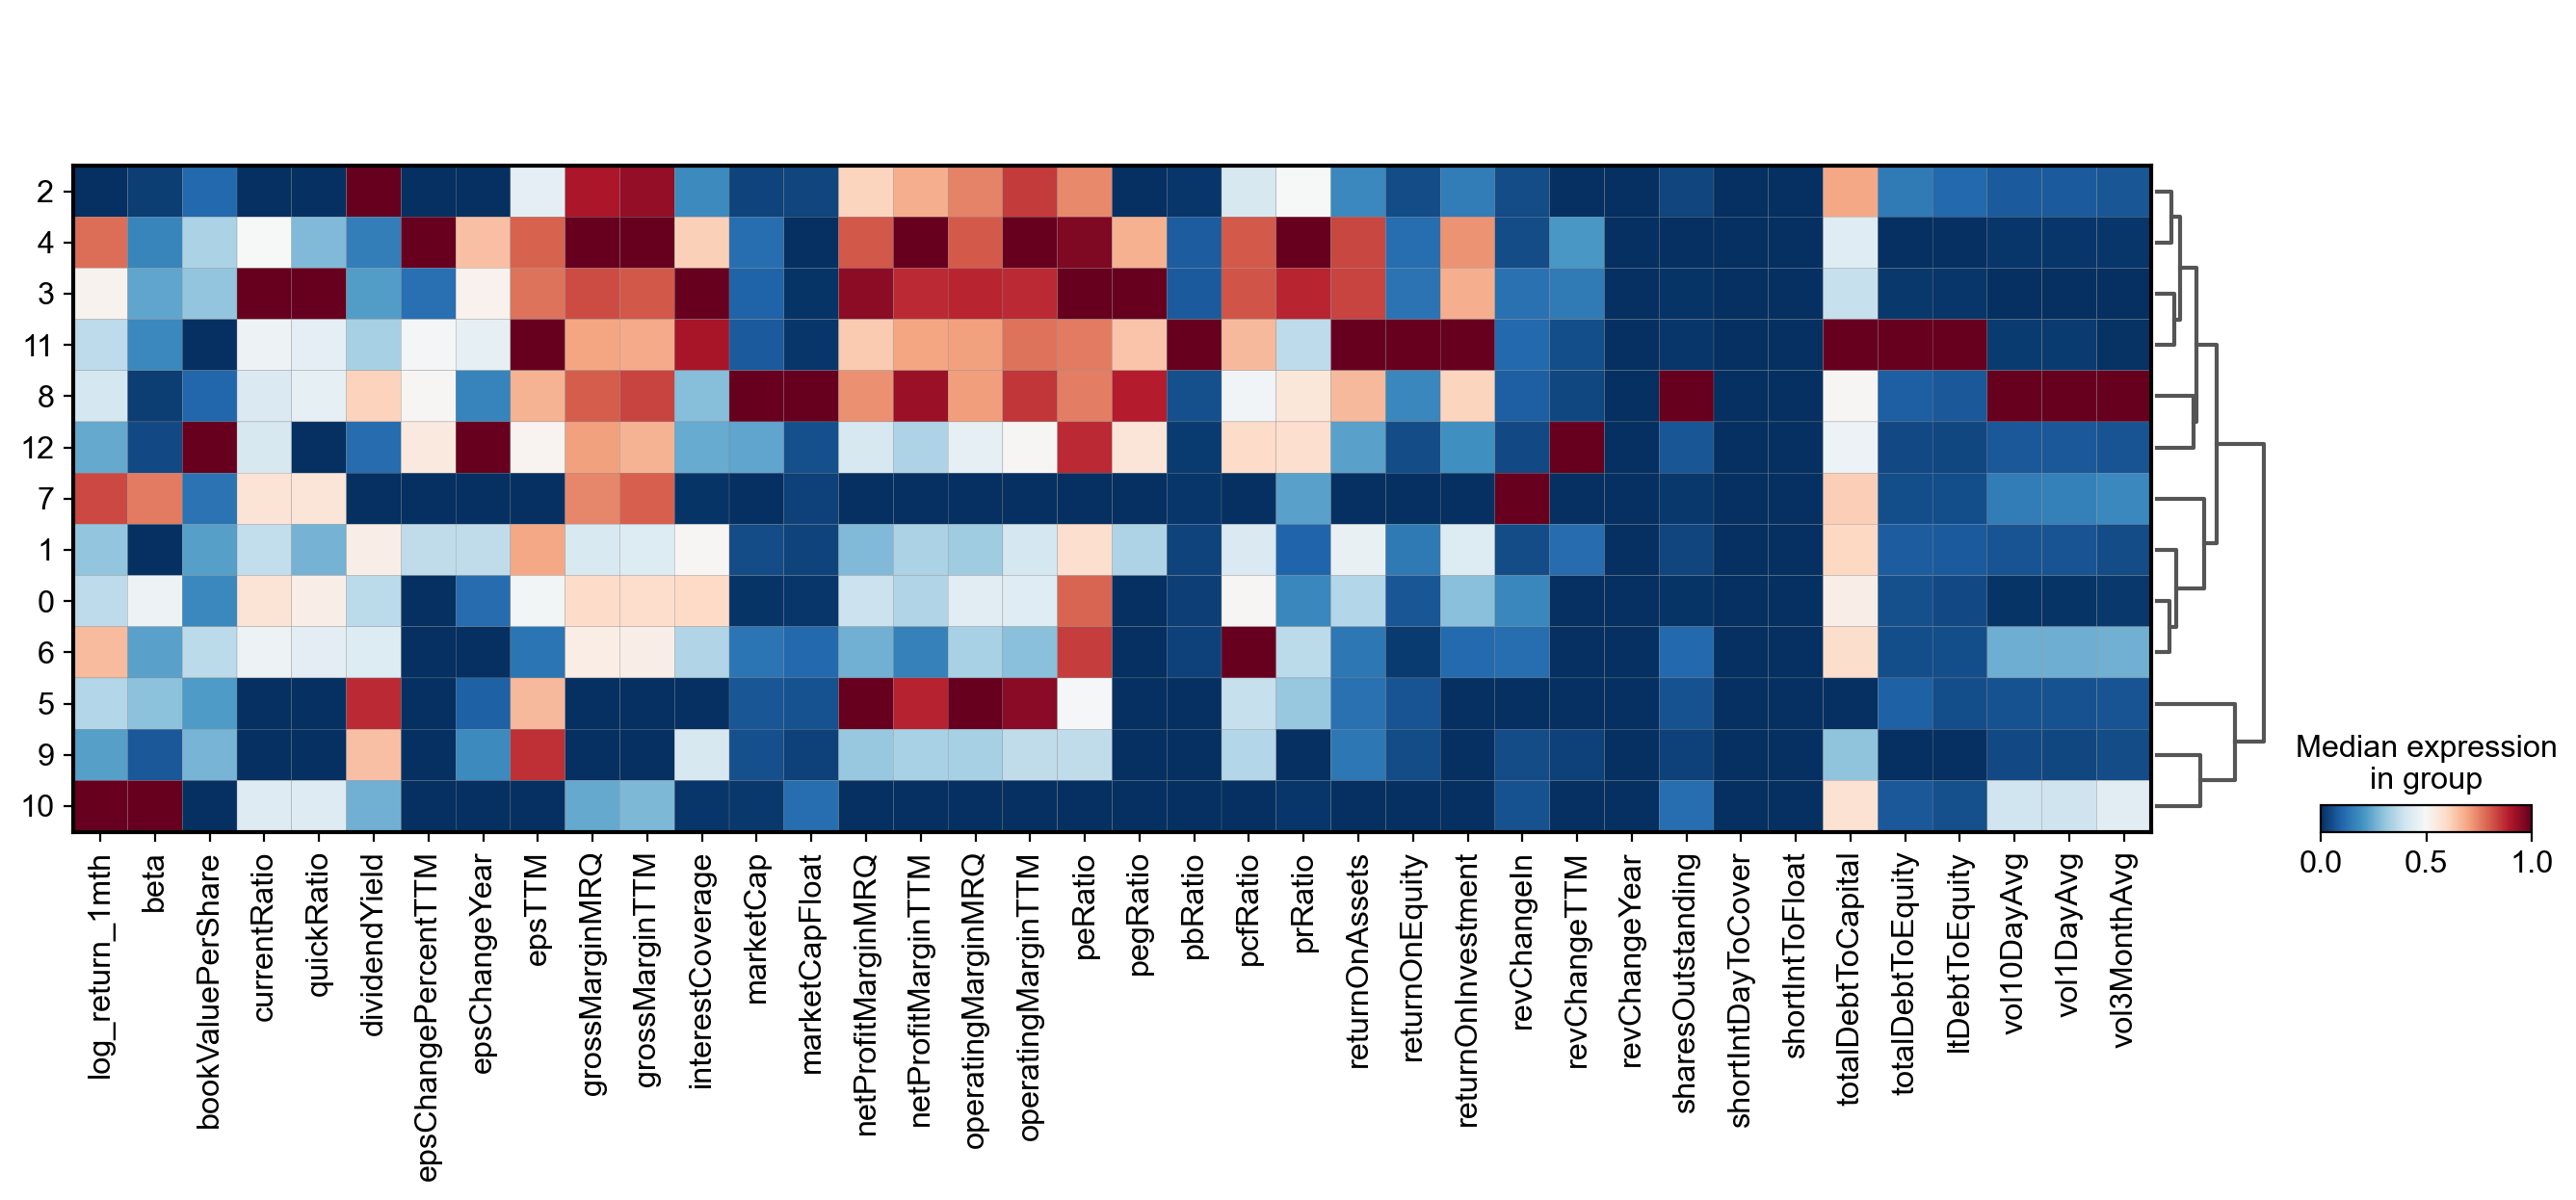

In [27]:
qp.pl.matrixplot(adata, var_names=adata.var_names, groupby='leiden', use_raw=False, 
              cmap='RdBu_r', dendrogram=True, standard_scale='var')

The matrixplot shows the median for each cluster/group of companies. Again, we are seeing Cluster 10 was the top performer in 'log_return_1mth', followed by Cluster 7, Cluster 4, and Cluster 6. Besides, we can also see that the 'beta' was high in both Clusters 10 and 7. In order to confirm the results, we are printing out the exact median for each cluster/group in dataframe.

In [28]:
df_leiden = pd.DataFrame(adata.obs['leiden'])
df_all = pd.merge(df_fundamental_logreturn, df_leiden, how='inner', left_index=True, right_index=True)
df_all[['GICS_Sector', 'GICS_SubIndustry']] = df_fundamental_logreturn[['GICS Sector', 'GICS Sub-Industry']]

# sort clusters by median log_return_1mth
stats_perCluster = df_all.groupby(['leiden']).agg({'log_return_1mth': ['median', 'min', 
                     'max', 'mean']}).dropna()
stats_perCluster.columns = ['median', 'min', 'max', 'mean']
stats_perCluster.sort_values(['median'], ascending=False).style.background_gradient(cmap='bwr', axis=0)

Dataframe above shows that the median of 'log_return_1mth' was the highest in Leiden Cluster 10, while the lowest were Cluster 2. To confirm the 'beta', we did the similar in the following cell. We typically dislike high beta as it usually means the company is [more risky](https://www.investopedia.com/investing/beta-know-risk/).

In [29]:
# sort clusters by median beta
stats_perCluster = df_all.groupby(['leiden']).agg({'beta': ['median', 'min', 
                     'max', 'mean']}).dropna()
stats_perCluster.columns = ['median', 'min', 'max', 'mean']
stats_perCluster.sort_values(['median'], ascending=False).style.background_gradient(cmap='bwr', axis=0)

## Visualizing the important features defining each cluster
Instead of looking at all features of clusters as previously, we can identify features/metrics that are differentially characterizing each cluster. Here, we can see that the Cluster 10 was significantly postive-correlated with higher beta, volatility 3-month average (vol3MonthAvg), volatility 10-day average (vol10DayAvg), vol1DayAvg, but negatively associated with lower earning per share Trailing-twelve-month (epsTTM), price per earning ration (peRatio), operatingMarginTTM, netProfitMarginTTM, returnOnAssets, etc. 

The worst performer, Cluster 2, was associated with higher dividendYield, grossMarginMRQ, grossMarginTTM, TotalDebtToEquity, etc, and lower current, quick ratio, returnOnAssets, etc.

Here, the author is particularly interested in the companies from the Cluster 4, which associated with lower beta, that typically means that the stocks in this cluster are considered less risky. Of note, the Cluster 4 were associated with favorable higher Operating Profitability Factors ('netProfitMarginTTM', 'netProfitMarginMRQ', 'grossMarginTTM', 'grossMarginMRQ', 'returnOnInvestment', 'returnOnAssets', 'operatingMarginTTM', 'operatingMarginMRQ') and lower Financial Risk Factors ('ITDebtToEquity' and 'TotalDebtToEquity')

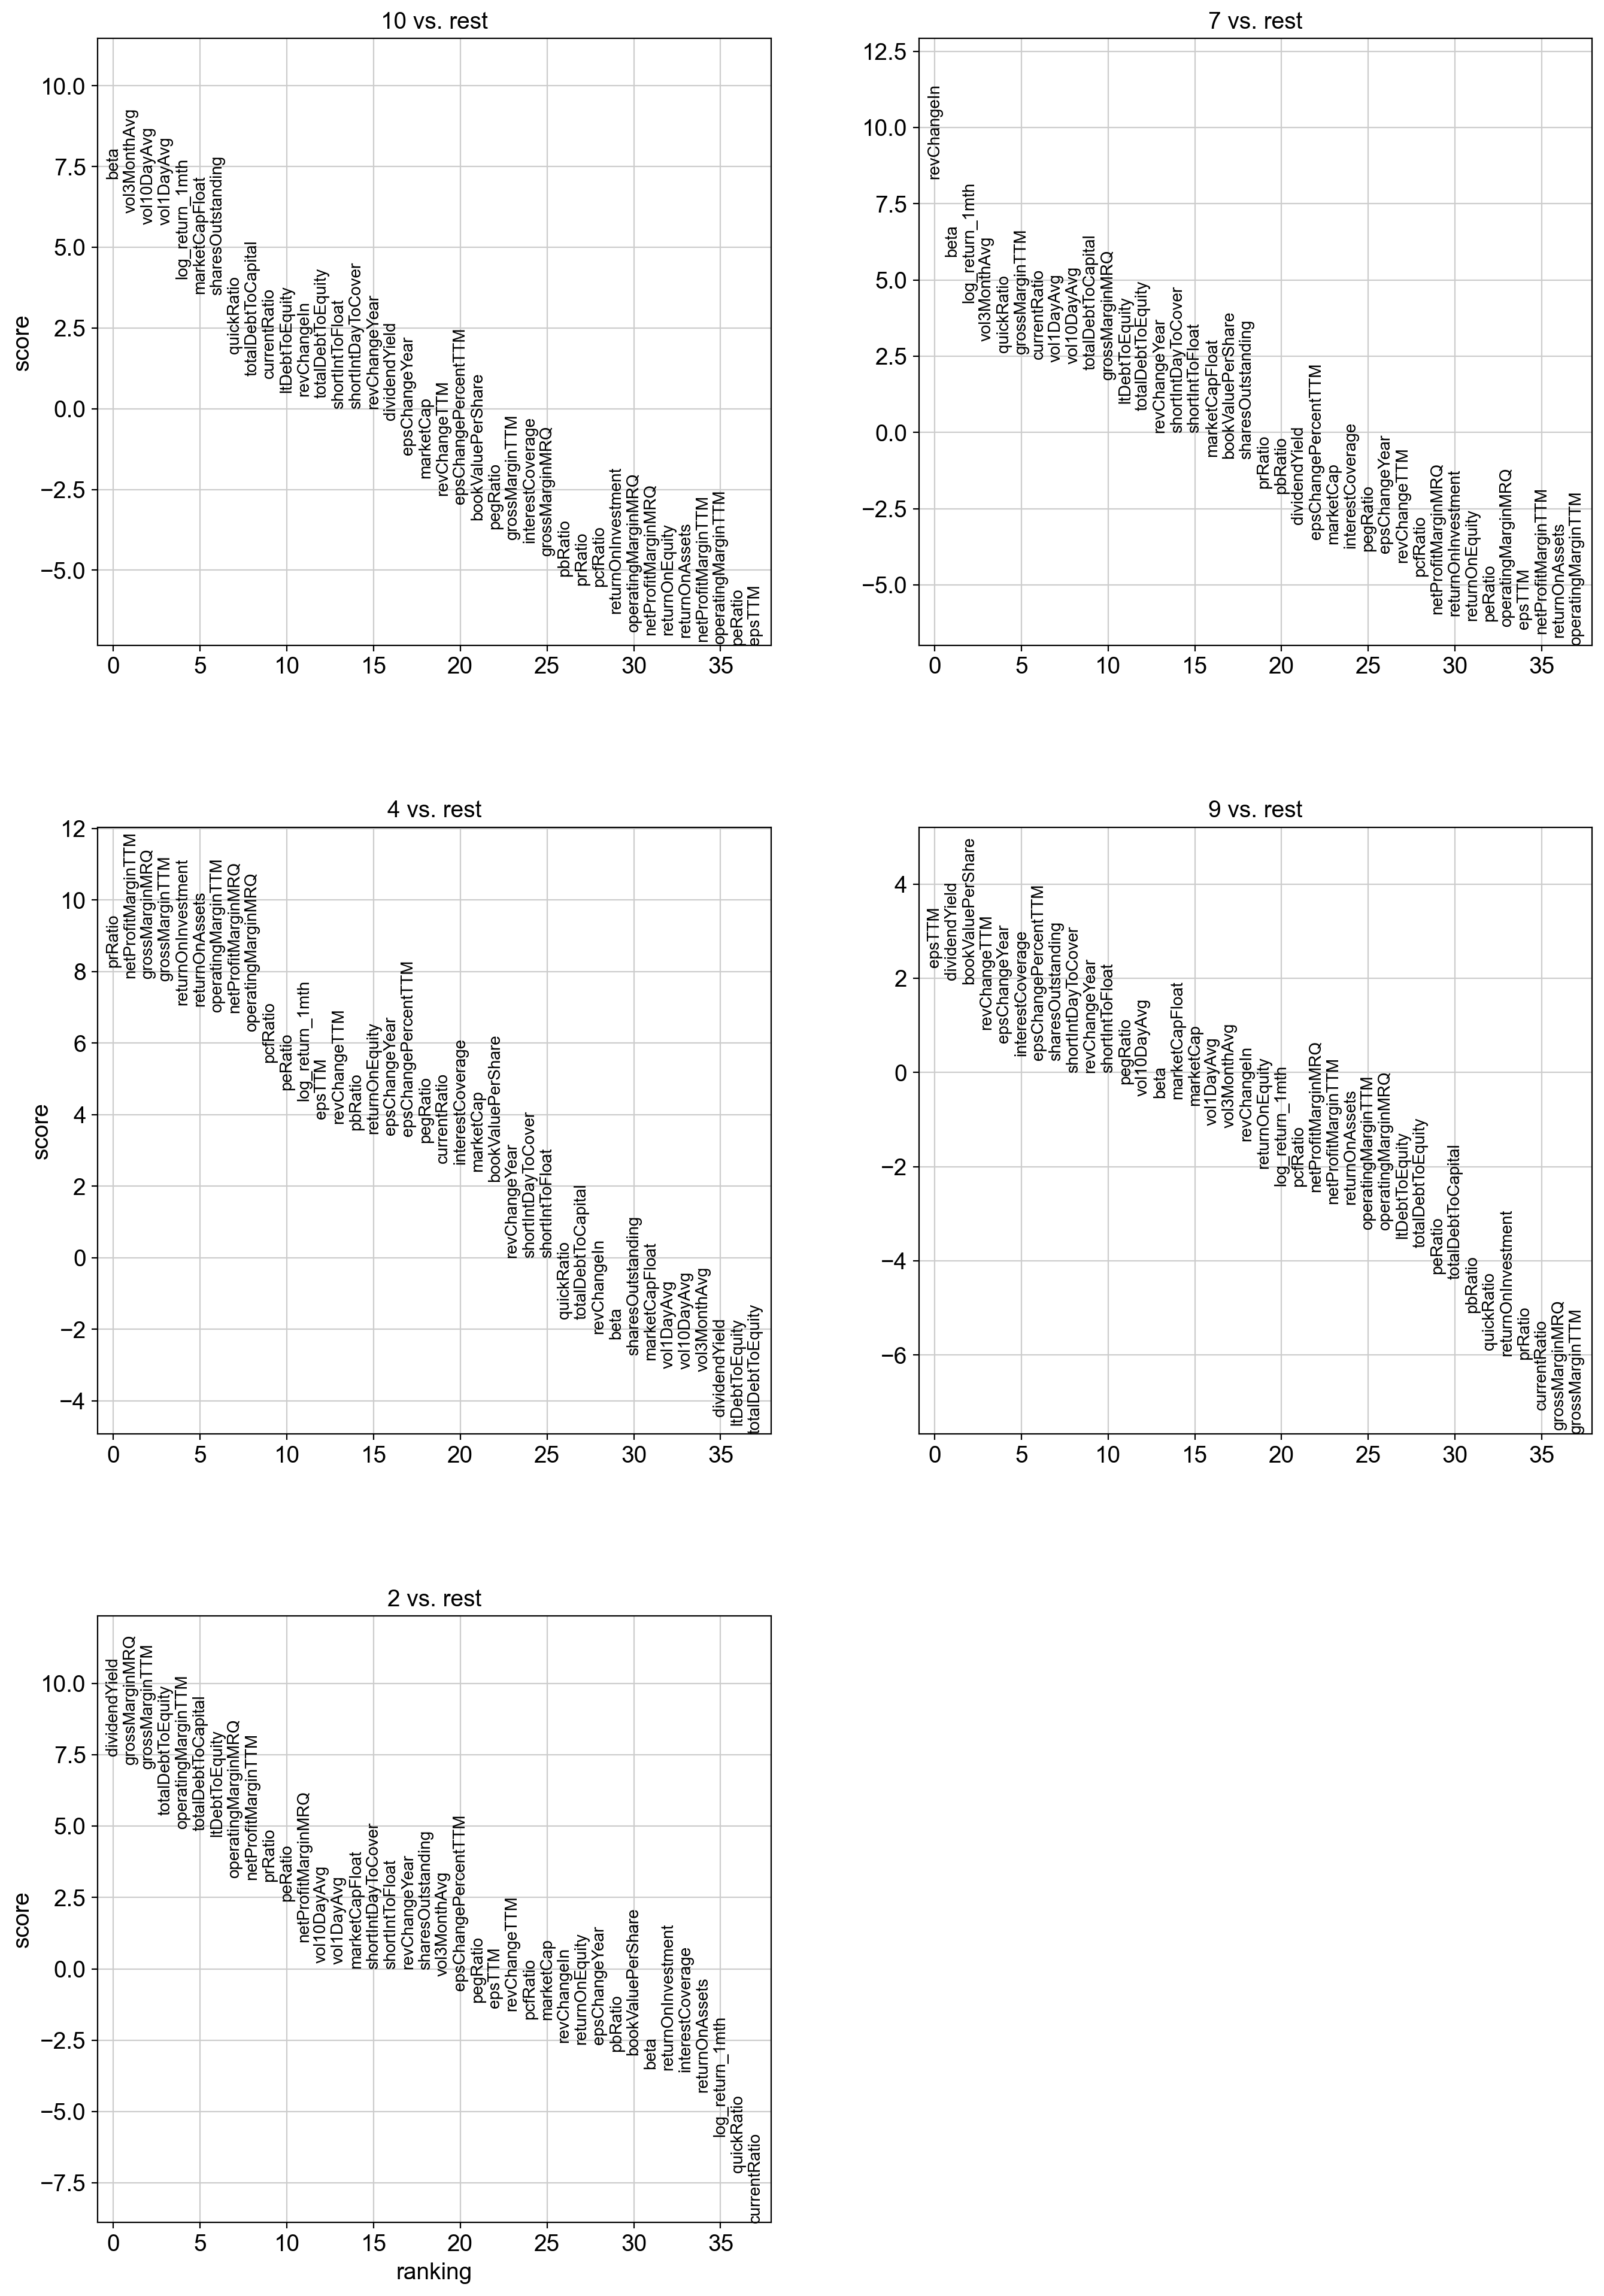

In [30]:
qp.tl.rank_features_groups(adata, 'leiden', groups=['10', '7', '4', '9', '2'], method='wilcoxon')
qp.pl.rank_features_groups(adata, n_features=38, sharey=False, fontsize=10, ncols=2)

We can map and view the annotations of leiden clustering based on the financial metrics/features on the umap plots below. Here, we see that Leiden Clusters 7 and 10 indeed mostly featured by high beta and unfavorable lower Operating Profitabiity Factors; Cluster 4 was featured by many favourable higher Operating Profitability Factors; Clusters 2 and 9 were featured by unfavorable lower Solvency Factors (current, quick ratios).

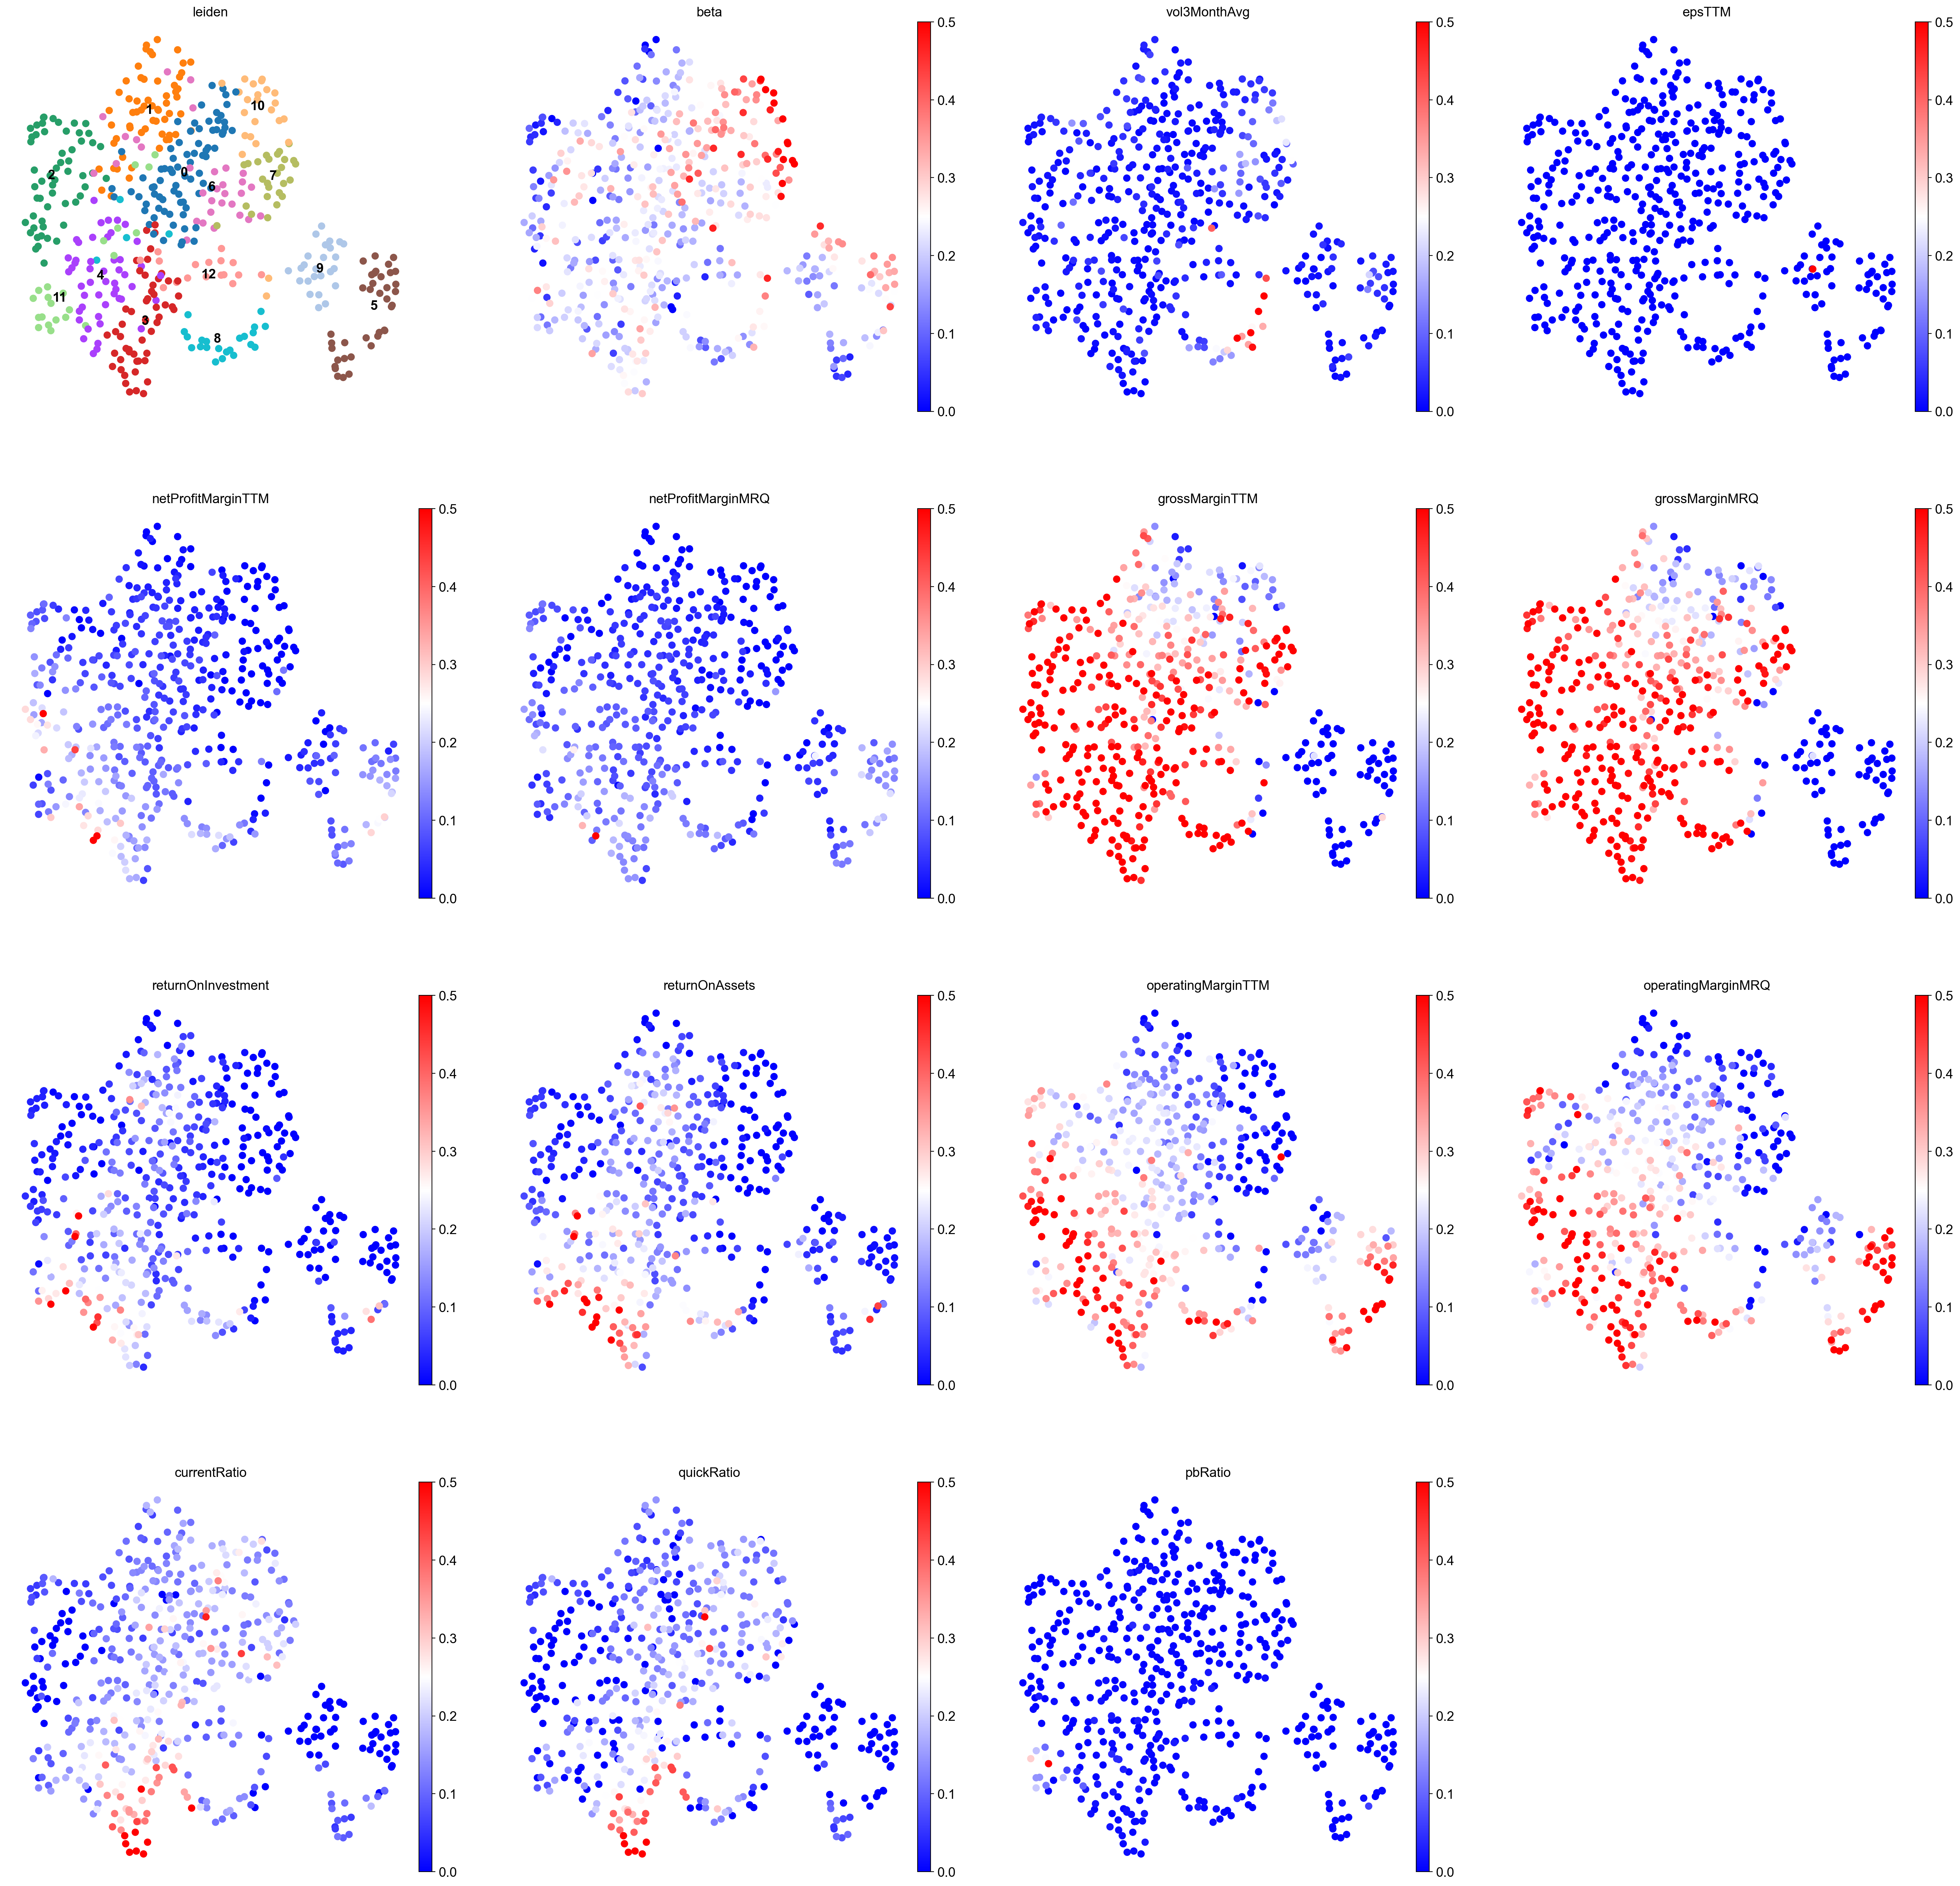

In [31]:
rcParams['figure.figsize'] = 8,8
qp.pl.umap(adata, color=['leiden', 'beta', 'vol3MonthAvg', 'epsTTM', 'netProfitMarginTTM', 
                         'netProfitMarginMRQ', 'grossMarginTTM', 'grossMarginMRQ', 
                         'returnOnInvestment', 'returnOnAssets', 'operatingMarginTTM', 
                         'operatingMarginMRQ', 'currentRatio', 'quickRatio', 'pbRatio'], 
           legend_loc='on data', frameon=False, ncols=4, cmap='bwr', vmax=0.5)

### Sector performance in the Cluster 4 companies

In [32]:
stats_perCluster = df_all.groupby(['leiden', 'GICS_Sector']).agg({'log_return_1mth': ['median', 'min', 'max', 'mean']}).dropna()

stats_perCluster.columns = ['median', 'min', 'max', 'mean']
stats_perCluster = stats_perCluster.reset_index()
stats_perCluster[stats_perCluster.leiden == '4'].sort_values(['median'], ascending=False).\
                                                style.background_gradient(cmap='bwr', axis=0)

In [33]:
# Printing out Cluster 4 companies
df_all[df_all.leiden == '4'][['Security', 'GICS Sector', 'GICS Sub-Industry']]

Security             GICS Sector  \
ATVI          Activision Blizzard  Communication Services   
ADBE                   Adobe Inc.  Information Technology   
AKAM      Akamai Technologies Inc  Information Technology   
ALGN             Align Technology             Health Care   
AMGN                   Amgen Inc.             Health Care   
ADI          Analog Devices, Inc.  Information Technology   
ANSS                        ANSYS  Information Technology   
ADP     Automatic Data Processing  Information Technology   
BIO          Bio-Rad Laboratories             Health Care   
BIIB                  Biogen Inc.             Health Care   
AVGO                Broadcom Inc.  Information Technology   
CDNS       Cadence Design Systems  Information Technology   
CHD               Church & Dwight        Consumer Staples   
STZ          Constellation Brands        Consumer Staples   
CSX                     CSX Corp.             Industrials   
DPZ                Domino's Pizza  Consumer Discretionary   
EBAY                    eBay Inc.  Consumer Discretionary   
EA                Electronic Arts  Communication Services   
EFX                  Equifax Inc.             Industrials   
ETSY                         Etsy  Consumer Discretionary   
FFIV                  F5 Networks  Information Technology   
FTNT                     Fortinet  Information Technology   
INFO              IHS Markit Ltd.             Industrials   
INTU                  Intuit Inc.  Information Technology   
JKHY      Jack Henry & Associates  Information Technology   
KSU          Kansas City Southern             Industrials   
MKTX                  MarketAxess              Financials   
MCD              McDonald's Corp.  Consumer Discretionary   
MCO                  Moody's Corp              Financials   
MSCI                     MSCI Inc              Financials   
NDAQ                 Nasdaq, Inc.              Financials   
NSC        Norfolk Southern Corp.             Industrials   
NLOK               NortonLifeLock  Information Technology   
ODFL    Old Dominion Freight Line             Industrials   
PAYC                       Paycom  Information Technology   
PYPL                       PayPal  Information Technology   
PKI                   PerkinElmer             Health Care   
PM    Philip Morris International        Consumer Staples   
ROL                  Rollins Inc.             Industrials   
ROP            Roper Technologies             Industrials   
NOW                    ServiceNow  Information Technology   
SNPS                Synopsys Inc.  Information Technology   
TTWO         Take-Two Interactive  Communication Services   
TYL            Tyler Technologies  Information Technology   
UNP            Union Pacific Corp             Industrials   
VRSN                Verisign Inc.  Information Technology   
V                       Visa Inc.  Information Technology   
VNT                       Vontier  Information Technology   
YUM               Yum! Brands Inc  Consumer Discretionary   

                          GICS Sub-Industry  
ATVI         Interactive Home Entertainment  
ADBE                   Application Software  
AKAM     Internet Services & Infrastructure  
ALGN                   Health Care Supplies  
AMGN                          Biotechnology  
ADI                          Semiconductors  
ANSS                   Application Software  
ADP      Internet Services & Infrastructure  
BIO          Life Sciences Tools & Services  
BIIB                          Biotechnology  
AVGO                         Semiconductors  
CDNS                   Application Software  
CHD                      Household Products  
STZ                   Distillers & Vintners  
CSX                               Railroads  
DPZ                             Restaurants  
EBAY     Internet & Direct Marketing Retail  
EA           Interactive Home Entertainment  
EFX          Research & Consulting Services  
ETSY     Internet & Direct Marketing Retail  
FFIV    

The sunburst chart below shows that Cluster 4 mostly consisted of Information Technology Sector, Cluster 10 mostly Energy Sector, Cluster 9 Financial Sector, and Cluster 2 Real Estate Sector.

In [38]:
import plotly.express as px

# grouping statistics
ds = df_all.groupby(['leiden', 'GICS_Sector', 'GICS_SubIndustry'])['log_return_1mth'].count().reset_index()
ds.columns = ['leiden', 'GICS_Sector', 'GICS_SubIndustry', 'count']

# plotting sunburst
fig = px.sunburst(
    ds, 
    path=[
        'leiden', 'GICS_Sector', 'GICS_SubIndustry'
    ], 
    values='count', 
    title='Sunburst chart',
    width=800,
    height=800
)
fig.show()

#### The sunburst chart below shows that most of the Real Estate companies Fall on the worst performer 1-month post vaccine success, Cluster 2.

In [37]:
import plotly.express as px
from itertools import repeat

Other_clusters = [c for c in df_all.leiden.unique() if c not in ['10', '7', '4', '9', '2']]
dict_regroup = {key: item for key, item in zip(Other_clusters, repeat('Others'))}
dict_regroup['10'] = 'C10 - Top performer'
dict_regroup['7'] = 'C7 - Second performer'
dict_regroup['4'] = 'C4 - Third (ideal) performer'
dict_regroup['9'] = 'C9 - Second to Worst performer'
dict_regroup['2'] = 'C2 - Worst performer'

df_regrouped = df_all.replace({'leiden': dict_regroup})

# grouping statistics
ds = df_regrouped.groupby(['GICS_Sector', 'leiden'])['log_return_1mth'].count().reset_index()
ds.columns = ['GICS_Sector', 'leiden', 'count']

# plotting sunburst
fig = px.sunburst(
    ds, 
    path=[
        'GICS_Sector','leiden'
    ], 
    values='count', 
    title='Sunburst chart',
    width=700,
    height=700
)
fig.show()

## Conclusions:-
In this tutorial, we found that the Cluster 10 was the top performer, followed by Clusters 7 and 4. However, Clusters 10 and 7 companies were associated with high beta - higher risk in stock market. Their performance were unjustifiable with statistically lower Operating Profit Factor. In comparison, Cluster 4 companies have lower beta - less risky, and its performance is justified by favorable higher Operating Profit Factor and lower Financial Risk Factors.

On the other hand, the worst performer was the Cluster 2, followed by Cluster 9. Both clusters have significantly lower solvency (current and quick ratios). Cluster 2 was also associated with higher financial risk, i.e. higher debt-to-capital/Equity. Of note, the cluster 2 was consisted mainly of the Real Estate companies. The worst performance probably justified by the on-going second wave during the current winter season, where city lockdown is widely adopted.